# Student Assessments: Graph Analysis

## Dataset Description: Student Assessment Questionnaires

The dataset `assessment_generated.csv` contains information derived from student assessment questionnaires.

Each record represents an individual student's response and includes demographic, academic, and self-assessment information. The dataset comprises the following attributes:

- **`timestamp`**  
  The date and time when the assessment was submitted, formatted as `yyyy-mm-dd hh:mm:ss timezone`.

- **`netid`**  
  The encoded NetID of the student. Valid NetIDs must have a string length between 8 and 14 characters (inclusive). Entries falling outside this range are considered invalid.

- **`ruid`**  
  The encoded RUID of the student. A valid RUID is expected to contain exactly 18 characters. Any deviation from this length is considered invalid.

- **`section`**  
  The course section number as reported by the student. This field may contain inaccuracies, as some students provided incorrect section information.

- **`role`**  
  The academic standing of the student. Possible values include:
  - `Freshman`
  - `Sophomore`
  - `Junior`
  - `Senior`
  - `Graduate`
  - `Other`

- **`major`**  
  The declared major of the student. Accepted categories are:
  - `Computer Science`
  - `Electrical and Computer Engineering`
  - `Mathematics`
  - `Other`

- **Skill Proficiency Columns**  
  The following columns record students’ self-assessed proficiency levels in specific skills, rated on scales ranging from 0 up to a multiple of 5 (depending on the number of questions per topic). Missing values are present in some entries.

  - `data_structures`  
  - `calculus_and_linear_algebra`  
  - `probability_and_statistics`  
  - `data_visualization`  
  - `python_libraries`  
  - `shell_scripting`  
  - `sql`  
  - `python_scripting`  
  - `jupyter_notebook`  
  - `regression`  
  - `programming_languages`  
  - `algorithms`  
  - `complexity_measures`  
  - `visualization_tools`  
  - `massive_data_processing`


## Tasks

### Part I: Data Wrangling

*Note: This section follows a similar procedure to the previous bonus assignment.*

1.  **Handle Missing Values**
    *   Impute missing values in each skill proficiency column with the mean of that column.

2.  **Remove Duplicate Records**
    *   Eliminate duplicate entries, retaining only the record with the most recent `timestamp`.

3.  **Normalize Skill Proficiency**
    *   Apply both *z-score normalization* and *0-1 scaling* to each skill proficiency column. Retain both normalized versions for subsequent analysis.

4.  **Calculate Total Score**
    *   Generate a `total_score` column by summing the *z-score normalized* values across all skill proficiency topics for each student.

---

### Part II: Generating Graphs from Student Assessment Data

1.  **Data Inspection**
    *   Visualize the distribution of each skill proficiency topic using histograms for both 0-1 scaled scores and z-scores.

2.  **Define Distance Metric**
    *   Employ the *Euclidean distance* to quantify the similarity between students based on their normalized skill proficiency vectors.
      For students $A$ and $B$ with skill vectors $S_A$ and $S_B$:
      $$
      d(A, B) = \sqrt{\sum_{i=1}^{n} (S_{A,i} - S_{B,i})^2}
      $$
    *   Plot the distribution of all pairwise distances in a histogram.
    *   Apply *z-score normalization* to the computed pairwise distances.

3.  **Graph Construction Based on Distance Thresholds**
    *   Establish one or more thresholds at specified standard deviations (e.g., 3, 2, and 1) *below the mean distance*.
    *   For each threshold, construct an *undirected graph*. An edge is created between students $A$ and $B$ if their distance $d(A, B)$ is below the given threshold.
    *   Assign a name to each graph corresponding to the standard deviation used for its construction (e.g., `Student_Assessment_Graph_-3SD`, `Student_Assessment_Graph_-2SD`, `Student_Assessment_Graph_-1SD`).
        *   What can be inferred about the graph connectivity as the threshold varies? Specifically, compare the number of edges in `Student_Assessment_Graph_-3SD`, `Student_Assessment_Graph_-2SD`, and `Student_Assessment_Graph_-1SD`.

4.  **Graph Analysis**
    *   For each constructed graph, compute and report the following metrics:
        *   Number of nodes and edges.
        *   Average degree.
        *   Degree distribution, visualized as a scatter plot with a vertical line indicating the average degree.
        *   Identify the top 10% of students by degree. List their `netid`s and `total_score`s.
            *   Highlight the data points for these top 10% of students on the scatter plot.
              *(Reference: [Matplotlib Annotations](https://matplotlib.org/stable/tutorials/text/annotations.html))*.
        *   Number of connected components.
        *   Plot the edge and vertex size distributions of connected components as scatter plots, with vertical lines indicating the average sizes.
    *   **Visualization**
        *   Render each graph using a *force-directed layout* (e.g., `spring_layout` in NetworkX).
          *(Reference: [NetworkX Spring Layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html))*.
        *   Color the nodes in the visualizations based on their `total_score` using a suitable colormap.
          *(Reference: [Matplotlib Colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html))*.
        *   Save each graph in JSON format and create interactive visualizations using:
            *   [2D Force Graph](https://github.com/vasturiano/force-graph)
            *   [3D Force Graph](https://github.com/vasturiano/3d-force-graph)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
#%pip install networkx # I didn't have this installed so run this command if missing module
import math
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import json
from itertools import chain, combinations

# Define skill columns
skill_columns = [
    'data_structures', 'calculus_and_linear_algebra', 'probability_and_statistics',
    'data_visualization', 'python_libraries', 'shell_scripting', 'sql',
    'python_scripting', 'jupyter_notebook', 'regression', 'programming_languages',
    'algorithms', 'complexity_measures', 'visualization_tools', 'massive_data_processing'
]

In [2]:
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv('assessment_generated.csv')
    display(df.head())
    df.info()

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-04 01:21:03 +0300,d2dbd3d0d5,786a2021217c6e2022,1,Junior,Computer Science,28.0,20.0,41.0,28.0,...,5.0,5.0,0.0,5.0,12.0,22.0,20.0,4.0,14.0,9.0
1,2025-09-04 00:28:39 +0200,c7dd9ac7c494,60703e393965793e3d,1,Junior,Computer Science,7.0,11.0,15.0,11.0,...,0.0,5.0,1.0,NaN,0.0,15.0,9.0,4.0,1.0,2.0
2,2025-09-03 18:22:47 -0400,5d504543461b,0f1d55565609195250,1,Senior,Mathematics,22.0,15.0,22.0,22.0,...,NaN,5.0,0.0,0.0,4.0,15.0,NaN,NaN,9.0,1.0
3,2025-09-04 06:29:53 +0800,021b4e0503,5145080b0b52450c0a,3,Senior,Computer Science,29.0,19.0,55.0,28.0,...,1.0,5.0,5.0,1.0,NaN,27.0,32.0,10.0,NaN,8.0
4,2025-09-03 16:31:34 -0600,8b8cc28089de,5d4c0104045b490005,1,Junior,Computer Science,25.0,14.0,43.0,23.0,...,1.0,5.0,1.0,1.0,12.0,13.0,7.0,0.0,6.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   timestamp                    157 non-null    object 
 1   netid                        157 non-null    object 
 2   ruid                         157 non-null    object 
 3   section                      157 non-null    int64  
 4   role                         157 non-null    object 
 5   major                        157 non-null    object 
 6   data_structures              148 non-null    float64
 7   calculus_and_linear_algebra  151 non-null    float64
 8   probability_and_statistics   152 non-null    float64
 9   data_visualization           151 non-null    float64
 10  python_libraries             147 non-null    float64
 11  shell_scripting              154 non-null    float64
 12  sql                          152 non-null    float64
 13  python_scripting    

# Part I: Data Wrangling

### 1. Handle Missing Values

In [3]:
def handle_missing_values(df, columns):
    """
    Fills missing values in specified columns with their respective column means.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    columns: list of str, the columns to fill.
    
    OUT:
    df: pd.DataFrame, the dataframe with missing values filled.
    """
    df_filled = df.copy()
    for col in columns:
        if col in df_filled.columns:
            s = pd.to_numeric(df_filled[col], errors="coerce")
            m = s.mean(skipna=True)
            df_filled[col] = s.fillna(m).astype(float)
    return df_filled

In [4]:
if __name__ == "__main__":
    df_filled = handle_missing_values(df.copy(), skill_columns)
    display(df_filled.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-04 01:21:03 +0300,d2dbd3d0d5,786a2021217c6e2022,1,Junior,Computer Science,28.0,20.0,41.0,28.0,...,5.00000,5.0,0.0,5.000000,12.000000,22.0,20.000000,4.00000,14.00000,9.0
1,2025-09-04 00:28:39 +0200,c7dd9ac7c494,60703e393965793e3d,1,Junior,Computer Science,7.0,11.0,15.0,11.0,...,0.00000,5.0,1.0,2.369128,0.000000,15.0,9.000000,4.00000,1.00000,2.0
2,2025-09-03 18:22:47 -0400,5d504543461b,0f1d55565609195250,1,Senior,Mathematics,22.0,15.0,22.0,22.0,...,1.11039,5.0,0.0,0.000000,4.000000,15.0,12.879195,3.75817,9.00000,1.0
3,2025-09-04 06:29:53 +0800,021b4e0503,5145080b0b52450c0a,3,Senior,Computer Science,29.0,19.0,55.0,28.0,...,1.00000,5.0,5.0,1.000000,4.061644,27.0,32.000000,10.00000,3.90411,8.0
4,2025-09-03 16:31:34 -0600,8b8cc28089de,5d4c0104045b490005,1,Junior,Computer Science,25.0,14.0,43.0,23.0,...,1.00000,5.0,1.0,1.000000,12.000000,13.0,7.000000,0.00000,6.00000,0.0


### 2. Remove Duplicate Records

Drop duplicates based on `ruid`, retaining the record with the latest `timestamp`.

In [5]:
def remove_duplicates(df):
    """
    Removes duplicate entries based on 'ruid', keeping the one with the latest 'timestamp'.

    IN:
    df: pd.DataFrame, the input dataframe.
    
    OUT:
    df: pd.DataFrame, the dataframe with duplicates removed.
    """
    df_tmp = df.copy()
    df_tmp["_ts_parsed"] = pd.to_datetime(df_tmp["timestamp"], utc=True, errors="coerce")

    # Keep the latest per ruid
    df_tmp = df_tmp.sort_values(["ruid", "_ts_parsed"])
    df_dedup = df_tmp.drop_duplicates(subset="ruid", keep="last").copy()

    # Format like "YYYY-MM-DD HH:MM:SS+00:00" (ISO8601 with colon in offset)
    df_dedup["_ts_parsed"] = df_dedup["_ts_parsed"].dt.tz_convert("UTC")
    df_dedup["timestamp"] = df_dedup["_ts_parsed"].astype(str)

    df_dedup = (
        df_dedup.sort_values("_ts_parsed", ascending=False)
                .drop(columns="_ts_parsed")
                .reset_index(drop=True)
    )
    return df_dedup

In [6]:
if __name__ == "__main__":
    df_dedup = remove_duplicates(df_filled.copy())
    display(df_dedup.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-03 22:39:05+00:00,54490a53500a,fceeaca5a5fbeea3ac,3,Senior,Computer Science,35.0,15.0,44.0,35.0,...,5.0,5.000000,5.0,5.0,15.0,22.00,26.0,10.0,14.0,6.0
1,2025-09-03 22:38:56+00:00,c1c7c4cbc8,a7b6f8fefea1b2fcf7,4,Senior,Computer Science,10.0,7.0,13.0,10.0,...,1.0,5.000000,1.0,1.0,0.0,6.00,5.0,4.0,0.0,0.0
2,2025-09-03 22:38:55+00:00,534b5f535e,e3fabab9bae1f7b2bcbee8f1beb8,4,Junior,Computer Science,13.0,13.0,44.0,28.0,...,1.0,2.447368,1.0,1.0,0.0,15.14,1.0,0.0,4.0,0.0
3,2025-09-03 22:38:50+00:00,697760696d,7f6d252626786c2f25,4,Junior,Computer Science,30.0,18.0,47.0,31.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,2025-09-03 22:38:35+00:00,6e7832636338,cad8919393c0d89a93,1,Junior,Computer Science,11.0,8.0,31.0,18.0,...,1.0,1.000000,1.0,5.0,3.0,5.00,12.0,6.0,0.0,0.0


### 3. Normalize Skill Proficiency

The new columns for z-score normalization and 0-1 scaling should be named as follows:
- For a skill proficiency column named `skill_topic`, the z-score normalized column should be `skill_topic_zscore`.
- For a skill proficiency column named `skill_topic`, the 0-1 scaled column should be `skill_topic_01scale`.

In [7]:
def normalize_skills(df, columns):
    """
    Applies z-score normalization and 0-1 scaling to specified columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    columns: list of str, the columns to normalize.
    
    OUT:
    df: pd.DataFrame, the dataframe with added normalized columns.
    """

    
    d = df.copy()

    # Keep original column order to prepend before new cols
    original_cols = list(d.columns)

    # Normalize timestamp display to ISO8601 UTC with '+00:00' (does not drop any cols)
    if "timestamp" in d.columns:
        d["timestamp"] = (
            pd.to_datetime(d["timestamp"], utc=True, errors="coerce")
              .dt.tz_convert("UTC")
              .astype(str)
        )

    # Add z-score and 0–1 scaled columns
    for c in columns:
        if c not in d.columns:
            continue

        s = pd.to_numeric(d[c], errors="coerce")

        # z-score (population std, ddof=0)
        mu = s.mean(skipna=True)
        sd = s.std(skipna=True, ddof=0)
        if pd.notna(sd) and sd > 0:
            z = (s - mu) / sd
        else:
            z = pd.Series(0.0, index=s.index)
        d[f"{c}_zscore"] = z.astype(float)

        # 0–1 scaling
        xmin = s.min(skipna=True)
        xmax = s.max(skipna=True)
        if pd.notna(xmin) and pd.notna(xmax) and xmax > xmin:
            s01 = (s - xmin) / (xmax - xmin)
        else:
            s01 = pd.Series(0.0, index=s.index)
        d[f"{c}_01scale"] = s01.astype(float)

    # Reorder: originals first, then all *_zscore (in 'columns' order), then *_01scale
    zcols  = [f"{c}_zscore"  for c in columns if f"{c}_zscore"  in d.columns]
    s01cols= [f"{c}_01scale" for c in columns if f"{c}_01scale" in d.columns]
    d = d[original_cols + zcols + s01cols]

    return d

In [8]:
if __name__ == "__main__":
    df_normalized = normalize_skills(df_dedup.copy(), skill_columns)
    display(df_normalized.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting_01scale,sql_01scale,python_scripting_01scale,jupyter_notebook_01scale,regression_01scale,programming_languages_01scale,algorithms_01scale,complexity_measures_01scale,visualization_tools_01scale,massive_data_processing_01scale
0,2025-09-03 22:39:05+00:00,54490a53500a,fceeaca5a5fbeea3ac,3,Senior,Computer Science,35.0,15.0,44.0,35.0,...,1.0,1.000000,1.0,1.0,1.0,0.785714,0.742857,1.0,0.608696,0.5
1,2025-09-03 22:38:56+00:00,c1c7c4cbc8,a7b6f8fefea1b2fcf7,4,Senior,Computer Science,10.0,7.0,13.0,10.0,...,0.2,1.000000,0.2,0.2,0.0,0.214286,0.142857,0.4,0.000000,0.0
2,2025-09-03 22:38:55+00:00,534b5f535e,e3fabab9bae1f7b2bcbee8f1beb8,4,Junior,Computer Science,13.0,13.0,44.0,28.0,...,0.2,0.489474,0.2,0.2,0.0,0.540714,0.028571,0.0,0.173913,0.0
3,2025-09-03 22:38:50+00:00,697760696d,7f6d252626786c2f25,4,Junior,Computer Science,30.0,18.0,47.0,31.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,2025-09-03 22:38:35+00:00,6e7832636338,cad8919393c0d89a93,1,Junior,Computer Science,11.0,8.0,31.0,18.0,...,0.2,0.200000,0.2,1.0,0.2,0.178571,0.342857,0.6,0.000000,0.0


### 4. Calculate Total Score

In [9]:
def compute_total_score(df, zscore_columns):
    """
    Computes the total score as the sum of z-score normalized skill columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    zscore_columns: list of str, the z-score normalized columns to sum.
    
    OUT:
    df: pd.DataFrame, the dataframe with the 'total_score' column.
    """

    d = df.copy()

    # Map provided names to existing *_zscore columns
    def _to_z(name: str):
        n = str(name)
        if n in d.columns:
            return n if n.endswith("_zscore") else (n + "_zscore" if (n + "_zscore") in d.columns else None)
        if n.endswith("_zscore") and n in d.columns:
            return n
        if n.endswith("_z"):
            cand = n[:-2] + "_zscore"
            return cand if cand in d.columns else None
        cand = n + "_zscore"
        return cand if cand in d.columns else None

    zcols = [c for c in (_to_z(c) for c in zscore_columns) if c is not None]

    if not zcols:
        d["total_score"] = np.nan
        return d

    block = d[zcols].apply(pd.to_numeric, errors="coerce")

    # Treat missing z-scores as 0 (i.e., at the column mean) for a consistent sum across skills
    block = block.fillna(0.0)

    d["total_score"] = block.sum(axis=1).astype(float)
    return d

In [10]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    final_df = compute_total_score(df_normalized, zscore_cols)
    display(final_df.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,sql_01scale,python_scripting_01scale,jupyter_notebook_01scale,regression_01scale,programming_languages_01scale,algorithms_01scale,complexity_measures_01scale,visualization_tools_01scale,massive_data_processing_01scale,total_score
0,2025-09-03 22:39:05+00:00,54490a53500a,fceeaca5a5fbeea3ac,3,Senior,Computer Science,35.0,15.0,44.0,35.0,...,1.000000,1.0,1.0,1.0,0.785714,0.742857,1.0,0.608696,0.5,24.514467
1,2025-09-03 22:38:56+00:00,c1c7c4cbc8,a7b6f8fefea1b2fcf7,4,Senior,Computer Science,10.0,7.0,13.0,10.0,...,1.000000,0.2,0.2,0.0,0.214286,0.142857,0.4,0.000000,0.0,-12.621991
2,2025-09-03 22:38:55+00:00,534b5f535e,e3fabab9bae1f7b2bcbee8f1beb8,4,Junior,Computer Science,13.0,13.0,44.0,28.0,...,0.489474,0.2,0.2,0.0,0.540714,0.028571,0.0,0.173913,0.0,-6.342962
3,2025-09-03 22:38:50+00:00,697760696d,7f6d252626786c2f25,4,Junior,Computer Science,30.0,18.0,47.0,31.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,-7.091736
4,2025-09-03 22:38:35+00:00,6e7832636338,cad8919393c0d89a93,1,Junior,Computer Science,11.0,8.0,31.0,18.0,...,0.200000,0.2,1.0,0.2,0.178571,0.342857,0.6,0.000000,0.0,-6.990046


# Part II: Generating Graphs from Student Assessment Data

### 1. Data Inspection

Note: Use the population standard deviation (`ddof=0`) for all standard deviation calculations.

In [11]:
def compute_mean_std(df, zscore_cols, scale01_cols):
    """
    Computes and prints the mean and standard deviation for z-score normalized
    and 0-1 scaled skill columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    zscore_cols: list of str, the z-score normalized columns.
    scale01_cols: list of str, the 0-1 scaled columns.

    OUT:
    mean_std: dict of dicts {column_name: {'mean': mean_value, 'std': std_value}}, where mean_value and std_value are np.float64 types.
    """
    ddof_used = 1  # sample std to match the slide

    def _resolve_cols(requested, df_cols, pairs):
        resolved = []
        for c in requested:
            if c in df_cols:
                resolved.append(c); continue
            for old_suf, new_suf in pairs:
                if isinstance(c, str) and c.endswith(old_suf):
                    cand = c[:-len(old_suf)] + new_suf
                    if cand in df_cols:
                        resolved.append(cand); break
        return resolved

    z_resolved = _resolve_cols(list(zscore_cols), set(df.columns),
                               [("_zscore","_z"),("_z","_zscore")])
    s_resolved = _resolve_cols(list(scale01_cols), set(df.columns),
                               [("_01scale","_01"),("_01","_01scale")])

    mean_std = {}
    for col in z_resolved + s_resolved:
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        # keep 0–1 range for scaled columns (prevents tiny round-off >1 or <0)
        if col.endswith(("_01scale","_01")):
            s = s[(s >= 0) & (s <= 1)]
        mean_std[col] = {
            "mean": np.float64(s.mean()),
            "std":  np.float64(s.std(ddof=ddof_used))
        }

    for k,v in mean_std.items():
        print(f"{k}: Mean = {v['mean']:.6f}, Std Dev = {v['std']:.6f}")
    return mean_std


To indicate the mean and standard deviation on the histograms, you may use the following functions:
- `plt.axvline()` to draw vertical lines at the mean.
- `plt.annotate()` to label these lines with their corresponding values.

**References:**
- [`plt.axvline()` Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)
- [`plt.annotate()` Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

**Example Usage:**
```python
# Plot a vertical line at x=0
plt.axvline(x=0, color='r', linestyle='--')

# Annotate the line with text
plt.annotate('Mean', xy=(0, 0), color='red')
```

In [12]:
def plot_skill_distributions(df, zscore_cols, scale01_cols, mean_std):
    """
    Plots histograms for z-score and 0-1 scaled skill proficiency columns.
    
    IN:
    df: pd.DataFrame, the dataframe containing the data.
    zscore_cols: list of str, the z-score normalized columns.
    scale01_cols: list of str, the 0-1 scaled columns.
    mean_std: dict of dicts, mean and std dev for each column.
    """
    

    n_bins_scaled = 35
    w = 1.0 / n_bins_scaled
    edges_scaled = np.arange(-w/2, 1 + w/2 + 1e-12, w)
    xpad_scaled = (w/2)

    bins_z = 35
    ddof_used = 1

    def _resolve_cols(requested, df_cols, pairs):
        resolved = []
        for c in requested:
            if c in df_cols:
                resolved.append(c); continue
            for old_suf, new_suf in pairs:
                if isinstance(c, str) and c.endswith(old_suf):
                    cand = c[:-len(old_suf)] + new_suf
                    if cand in df_cols:
                        resolved.append(cand); break
        return resolved

    z_resolved = _resolve_cols(list(zscore_cols), set(df.columns),
                               [("_zscore","_z"),("_z","_zscore")])
    s_resolved = _resolve_cols(list(scale01_cols), set(df.columns),
                               [("_01scale","_01"),("_01","_01scale")])

    def _plot_group(cols, is_z):
        if not cols:
            return
        n = len(cols)
        cols_per_row = 3
        rows = math.ceil(n / cols_per_row)
        plt.figure(figsize=(6 * cols_per_row, 3.8 * rows))

        for i, c in enumerate(cols, start=1):
            ax = plt.subplot(rows, cols_per_row, i)

            s = pd.to_numeric(df[c], errors="coerce").dropna()
            is_scaled = c.endswith(("_01scale","_01"))
            if is_scaled:
                s = s[(s >= 0) & (s <= 1)]

            if s.empty:
                ax.set_title(f"{c} (no data)")
                ax.axis("off")
                continue

            weights = np.ones(len(s), dtype=float) / max(len(s), 1)

            if is_scaled:
                ax.hist(s.values, bins=edges_scaled, weights=weights,
                        edgecolor="black", linewidth=0.5, align="mid")
                ax.set_xlim(-xpad_scaled, 1 + xpad_scaled)
                xlabel = "Score (0–1)"
            else:
                ax.hist(s.values, bins=bins_z, weights=weights,
                        edgecolor="black", linewidth=0.5)
                x_min, x_max = ax.get_xlim()
                pad = 0.02 * (x_max - x_min)
                ax.set_xlim(x_min - pad, x_max + pad)
                xlabel = "z-Score"

            if mean_std and c in mean_std and "mean" in mean_std[c] and "std" in mean_std[c]:
                m = float(mean_std[c]["mean"])
                sd = float(mean_std[c]["std"])
            else:
                m = float(s.mean())
                sd = float(s.std(ddof=ddof_used if not is_scaled else 0))

            plt.axvline(x=m, color="red", linestyle="--", linewidth=1)

            ymin, ymax = ax.get_ylim()
            x_min_ax, x_max_ax = ax.get_xlim()
            x_anno = x_min_ax + 0.65*(x_max_ax - x_min_ax)
            y_anno = ymin + 0.08*(ymax - ymin)
            plt.annotate(f"mean = {m:.3f}\nstd  = {sd:.3f}",
                         xy=(x_anno, y_anno),
                         color="red")

            base = (c.replace("_01scale","").replace("_01","")
                      .replace("_zscore","").replace("_z",""))
            base_title = base.replace("_"," ").title()
            title = f"{base_title} z-Score Distribution" if is_z else f"{base_title} (0–1) Distribution"
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Proportion")

        plt.tight_layout()
        plt.show()

    _plot_group(s_resolved, is_z=False)
    _plot_group(z_resolved, is_z=True)

data_structures_zscore: Mean = -0.000000, Std Dev = 1.003328
calculus_and_linear_algebra_zscore: Mean = -0.000000, Std Dev = 1.003328
probability_and_statistics_zscore: Mean = -0.000000, Std Dev = 1.003328
data_visualization_zscore: Mean = 0.000000, Std Dev = 1.003328
python_libraries_zscore: Mean = -0.000000, Std Dev = 1.003328
shell_scripting_zscore: Mean = -0.000000, Std Dev = 1.003328
sql_zscore: Mean = 0.000000, Std Dev = 1.003328
python_scripting_zscore: Mean = 0.000000, Std Dev = 1.003328
jupyter_notebook_zscore: Mean = 0.000000, Std Dev = 1.003328
regression_zscore: Mean = 0.000000, Std Dev = 1.003328
programming_languages_zscore: Mean = -0.000000, Std Dev = 1.003328
algorithms_zscore: Mean = -0.000000, Std Dev = 1.003328
complexity_measures_zscore: Mean = -0.000000, Std Dev = 1.003328
visualization_tools_zscore: Mean = -0.000000, Std Dev = 1.003328
massive_data_processing_zscore: Mean = 0.000000, Std Dev = 1.003328
data_structures_01scale: Mean = 0.604030, Std Dev = 0.215167
c

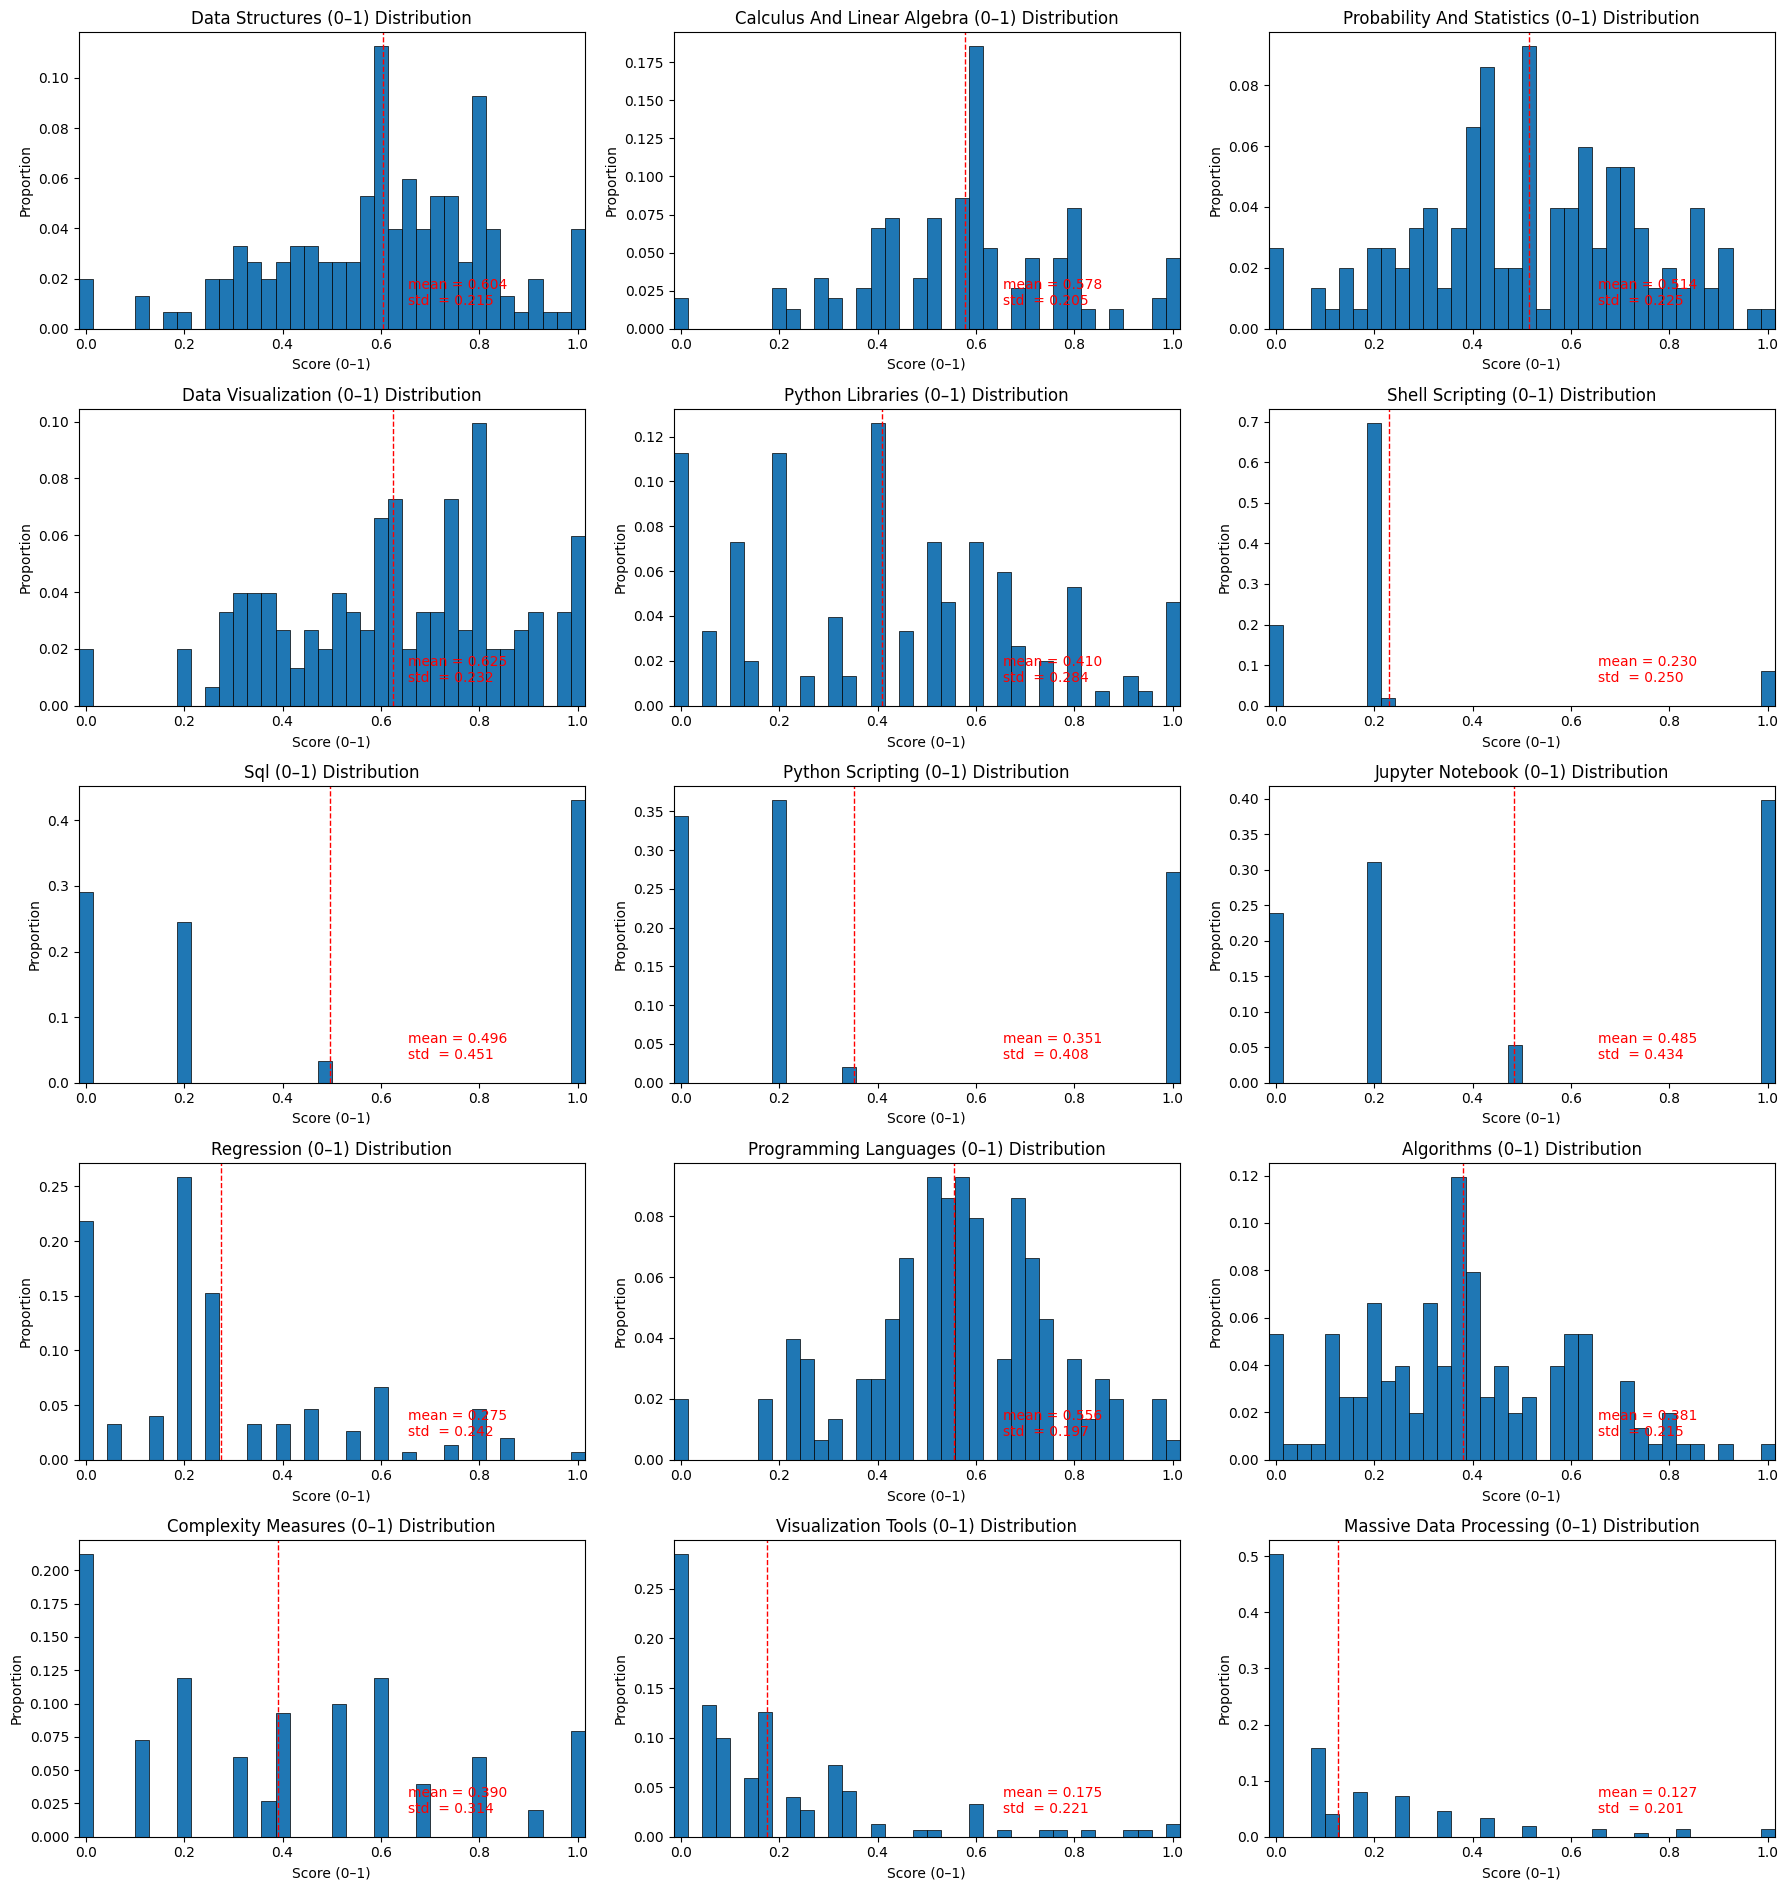

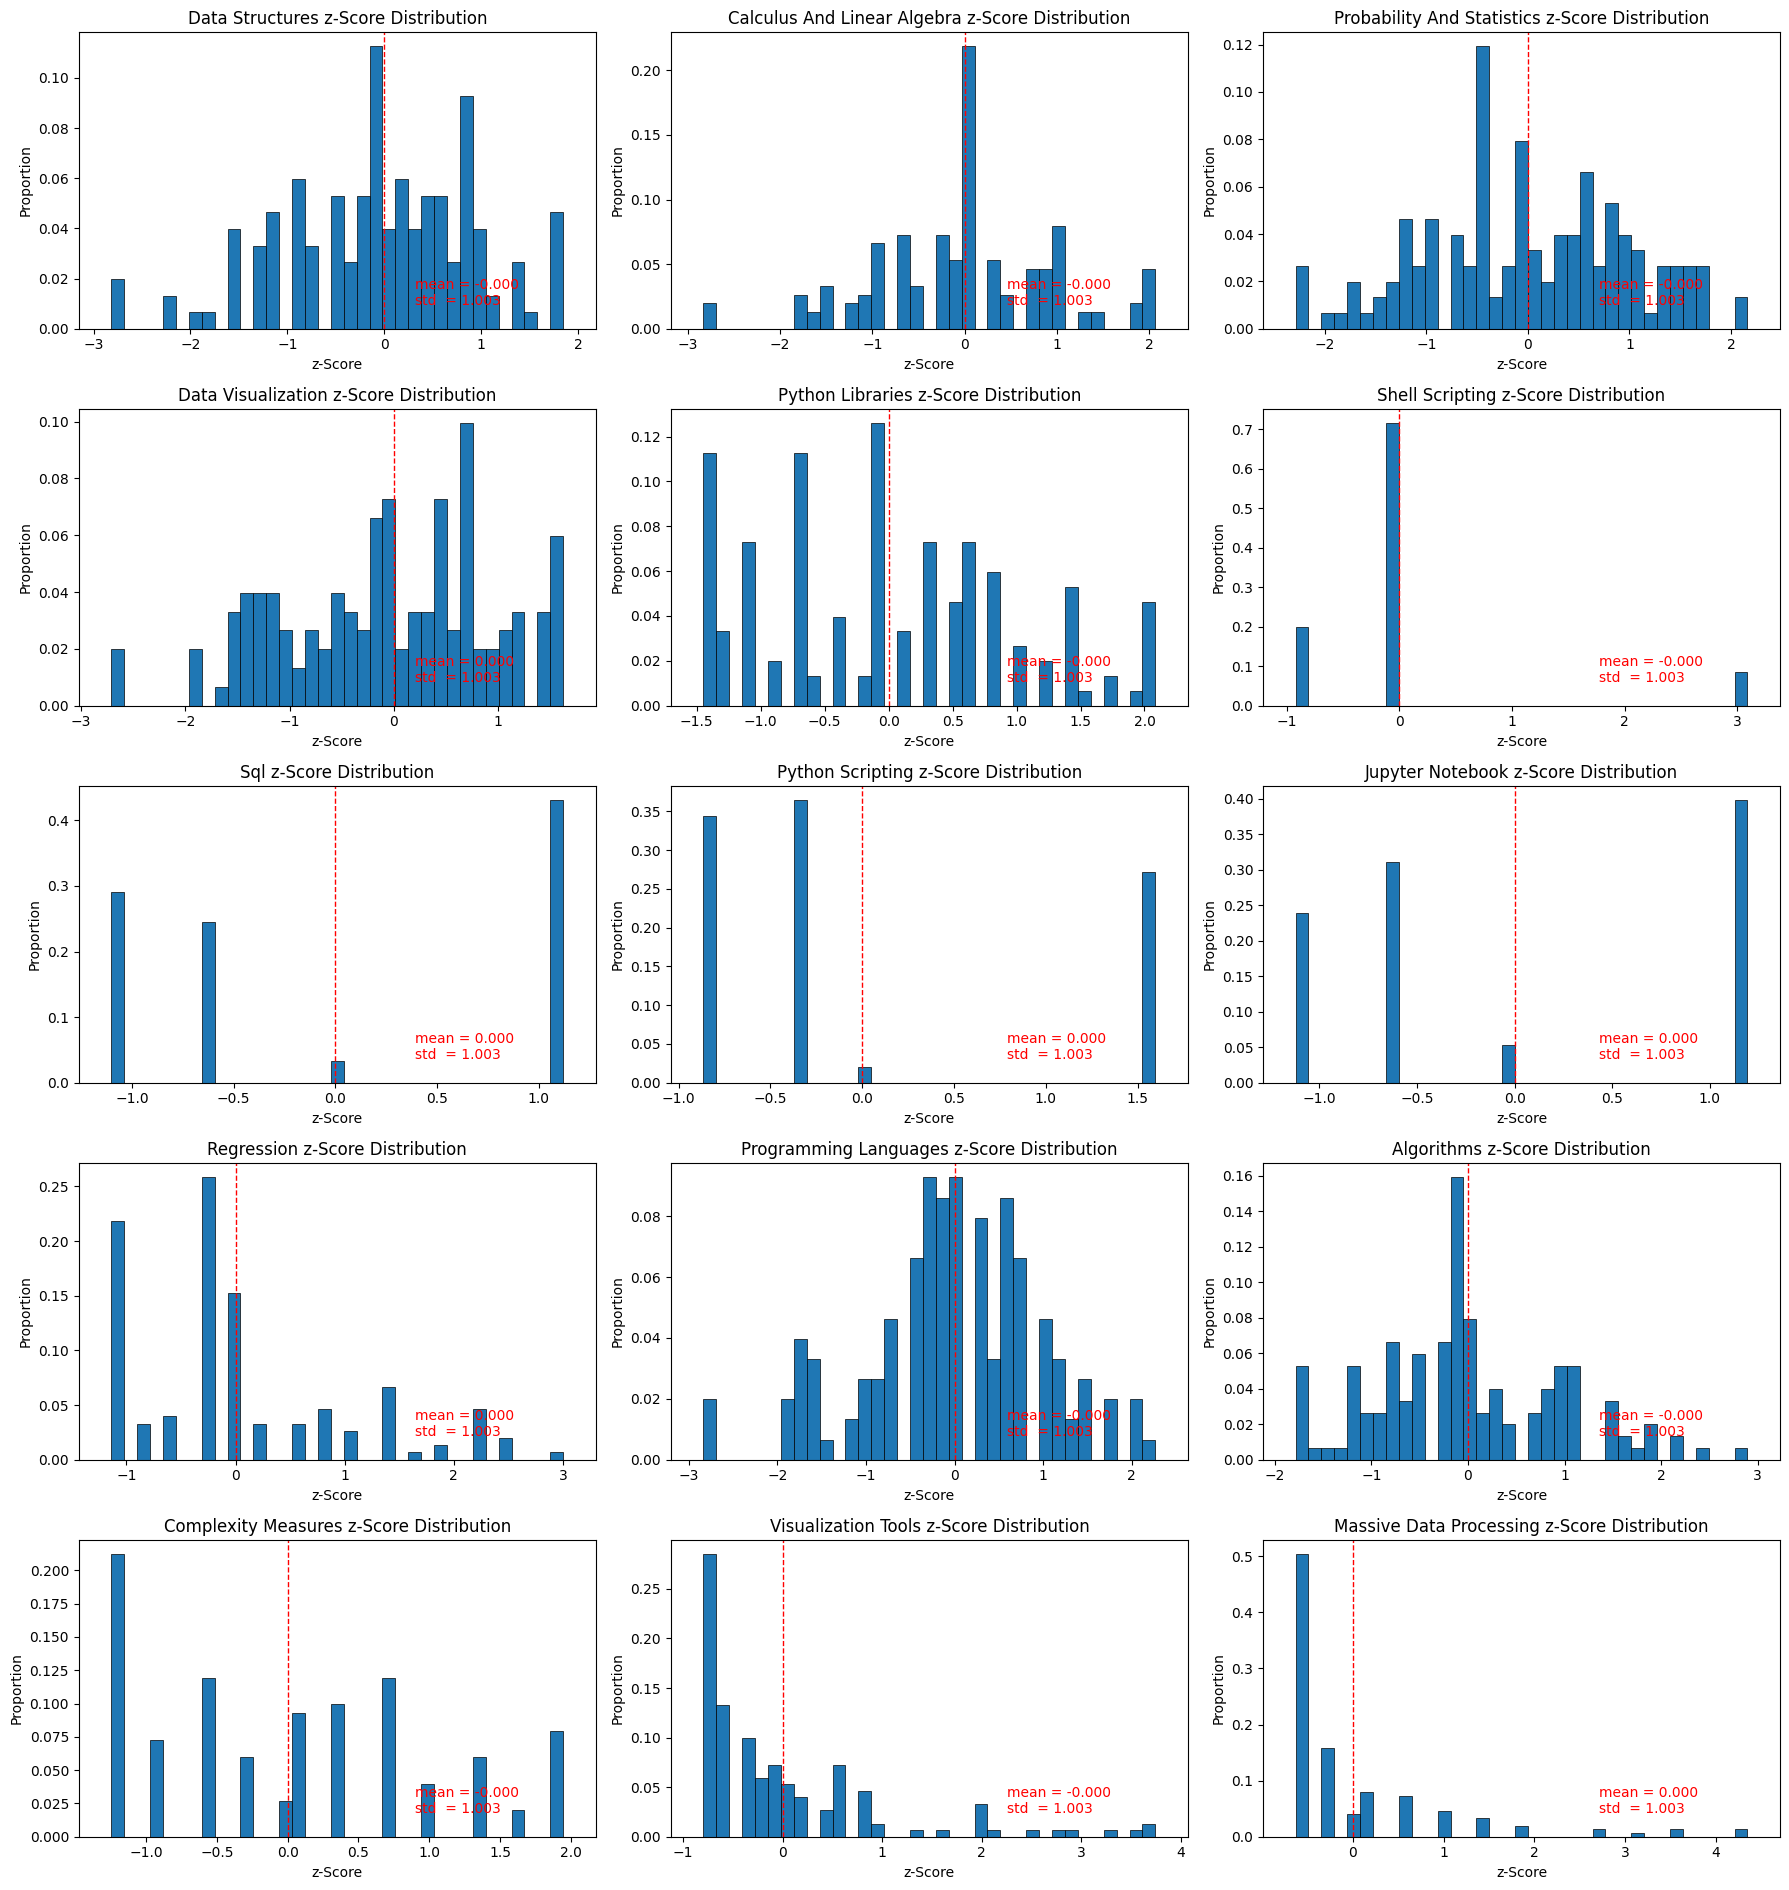

In [13]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    scale01_cols = [f'{c}_01scale' for c in skill_columns]
    mean_std = compute_mean_std(final_df, zscore_cols, scale01_cols)
    for col, stats in mean_std.items():
        print(f"{col}: Mean = {stats['mean']:.4f}, Std Dev = {stats['std']:.4f}")
    plot_skill_distributions(final_df, zscore_cols, scale01_cols, mean_std)

### 2. Define Distance Metric

Note: The returned distance matrix is expected to have a shape of `(len(df), len(df))`, where each entry `(i, j)` corresponds to the distance between `df.iloc[i]` and `df.iloc[j]`. Consequently, the diagonal entries `(i, i)` must be zero.

In [ ]:
def calculate_distances(df, zscore_cols):
    """
    Calculates pairwise Euclidean distances.
    
    IN:
    df: pd.DataFrame, the dataframe with student data.
    zscore_cols: list of str, columns to use for distance calculation.
    
    OUT:
    distances: np.array of shape (len(df), len(df)), pairwise distances.
    """
    from scipy.spatial.distance import pdist, squareform
    X = df[zscore_cols].to_numpy(dtype=float)
    return squareform(pdist(X, metric="euclidean"))

Note: The condensed distance matrix is a flattened array that contains the upper triangular portion of the distance matrix, excluding the diagonal. Specifically, the first `len(df) - 1` entries represent the distances between the first data point and all subsequent points; the next `len(df) - 2` entries represent the distances between the second data point and all subsequent points, and so on.

**References:**
- [`scipy.spatial.distance.pdist` Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)
- [`scipy.spatial.distance.squareform` Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)

In [15]:
def condense_distance_matrix(distances):
    """
    Condenses a square distance matrix into a condensed form.
    
    IN:
    distances: np.array of shape (len(df), len(df)), pairwise distances.
    
    OUT:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    """
    from scipy.spatial.distance import squareform
    return squareform(distances, force="tovector")

In [16]:
def squareform_distance_matrix(condensed_distances):
    """
    Converts a condensed distance matrix back to square form.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    
    OUT:
    distances: np.array of shape (len(df), len(df)), pairwise distances.
    """
   
    from scipy.spatial.distance import squareform
    return squareform(condensed_distances, force="tomatrix")

In [17]:

def normalize_distances(condensed_distances):
    """
    Applies z-score normalization to distances.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.

    OUT:
    condensed_distances_zscore: np.array of shape (len(df)*(len(df)-1)/2,), z-score normalized condensed pairwise distances.
    """
    arr = np.asarray(condensed_distances, dtype=float)
    if arr.ndim == 2 and arr.shape[0] == arr.shape[1]:
        n = arr.shape[0]
        iu = np.triu_indices(n, k=1)
        v = arr[iu].astype(float, copy=False)
    else:
        v = arr.ravel().astype(float, copy=False)

    if v.size == 0:
        return v.copy()

    finite = np.isfinite(v)
    if not finite.any():
        return np.zeros_like(v, dtype=float)

    mu = float(v[finite].mean())
    sd = float(v[finite].std(ddof=0))
    if not np.isfinite(sd) or sd == 0.0:
        z = np.zeros_like(v, dtype=float)
        z[~finite] = np.nan
        return z

    z = (v - mu) / sd
    z[~finite] = np.nan
    return z


Note: For all standard deviation calculations, use the population standard deviation, which corresponds to setting `ddof=0`.

In [18]:
def compute_dist_mean_std(condensed_distances):
    """
    Computes mean and standard deviation of the distances.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    
    OUT:
    mean: np.float64, mean of the distances.
    std: np.float64, standard deviation of the distances.
    """
    v = np.asarray(condensed_distances, dtype=float).ravel()
    finite = np.isfinite(v)
    if not finite.any():
        mean = np.float64(0.0)
        std  = np.float64(0.0)
    else:
        mean = np.float64(v[finite].mean())             # ddof=0 implicitly
        std  = np.float64(v[finite].std(ddof=0))        # population std
    return mean, std

In [19]:
def plot_distance_distribution(condensed_distances, mean, std, title='Distance Distribution'):
    """
    Plots the distribution of distances.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    mean: np.float64, mean of the distances.
    std: np.float64, standard deviation of the distances.
    title: str, the title of the plot.
    """
    v = np.asarray(condensed_distances, dtype=float).ravel()
    v = v[np.isfinite(v)]
    if v.size == 0:
        print("[warn] No finite distances to plot.")
        return

    plt.figure()
    counts, bins, _ = plt.hist(v, bins=30, density=True)   # proportions on y-axis
    ymax = counts.max() if len(counts) else 1.0

    # Vertical lines at mean and 1 SD
    plt.axvline(x=mean, linestyle="--")
    plt.axvline(x=mean - std, linestyle="--")
    plt.axvline(x=mean + std, linestyle="--")

    # Labels
    plt.annotate(f"Mean = {mean:.3f}", xy=(mean, 0), xytext=(5, 5),
                 textcoords="offset points", rotation=90, va="bottom")
    plt.annotate("-1 SD", xy=(mean - std, ymax * 0.9), xytext=(5, -10),
                 textcoords="offset points", rotation=90, va="top")
    plt.annotate("+1 SD", xy=(mean + std, ymax * 0.9), xytext=(5, -10),
                 textcoords="offset points", rotation=90, va="top")

    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

Original distances - Mean: 5.2492, Std Dev: 1.6265


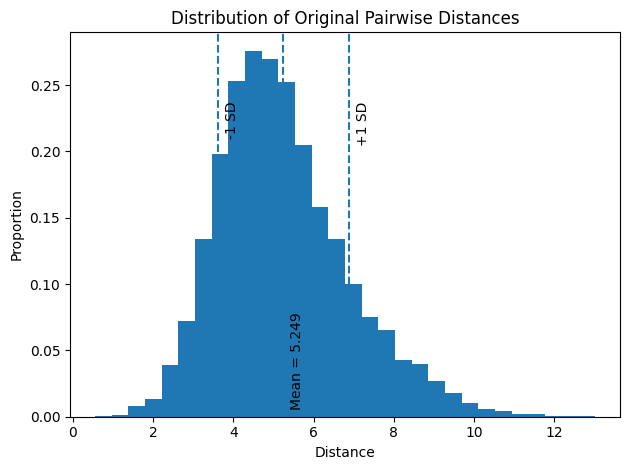

Normalized distances - Mean: -0.0000, Std Dev: 1.0000


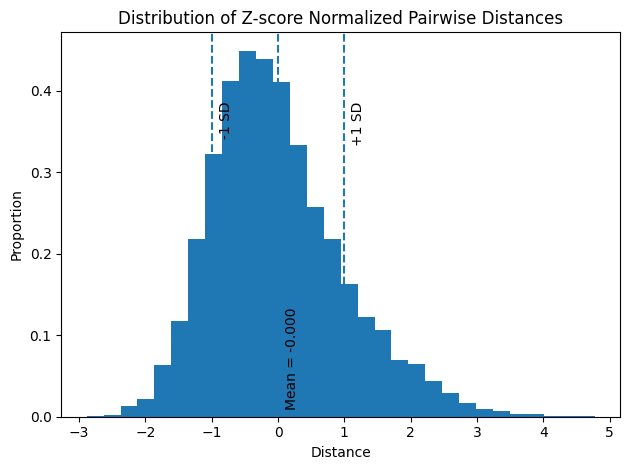

In [20]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    
    # Calculate and plot original distances
    distances = calculate_distances(final_df, zscore_cols)
    condense_distances = condense_distance_matrix(distances)
    mean, std = compute_dist_mean_std(condense_distances)
    print(f"Original distances - Mean: {mean:.4f}, Std Dev: {std:.4f}")
    plot_distance_distribution(condense_distances, mean, std, 'Distribution of Original Pairwise Distances')

    # Normalize and plot z-score distances
    normalized_condensed_distances = normalize_distances(condense_distances)
    mean, std = compute_dist_mean_std(normalized_condensed_distances)
    print(f"Normalized distances - Mean: {mean:.4f}, Std Dev: {std:.4f}")
    plot_distance_distribution(normalized_condensed_distances, mean, std, 'Distribution of Z-score Normalized Pairwise Distances')

    # Convert back to square form
    normalized_distances = squareform_distance_matrix(normalized_condensed_distances)

### 3. Graph Construction Based on Distance Thresholds

In [21]:
def construct_graph(df, distance_matrix, threshold, name):
    """
    Constructs a graph based on a distance threshold.
    
    IN:
    df: pd.DataFrame, dataframe with node information.
    distance_matrix: np.array, 
    threshold: float, the distance threshold for creating edges.
    name: str, the name of the graph.
    
    OUT:
    G: nx.Graph, the constructed graph.
    """
    Z_in = np.asarray(distance_matrix, dtype=float)

    # Condensed -> square, or validate square
    if Z_in.ndim == 1:
        m = Z_in.size
        n = int(round((1.0 + np.sqrt(1.0 + 8.0*m)) / 2.0))
        if n * (n - 1) // 2 != m:
            raise ValueError("Condensed length does not match n*(n-1)/2.")
        Z = np.zeros((n, n), dtype=float)
        iu = np.triu_indices(n, k=1)
        Z[iu] = Z_in
        Z[(iu[1], iu[0])] = Z_in
        np.fill_diagonal(Z, 0.0)
    elif Z_in.ndim == 2 and Z_in.shape[0] == Z_in.shape[1]:
        Z = Z_in.astype(float, copy=True)
        n = Z.shape[0]
        np.fill_diagonal(Z, 0.0)
    else:
        raise ValueError("distance_matrix must be square (n,n) or 1D condensed.")

    if len(df) != n:
        raise ValueError(f"df has {len(df)} rows but distance matrix implies {n} items")

    G = nx.Graph(name=name)

    # Nodes with unique, readable IDs
    keep = ["timestamp","netid","ruid","section","role","major","total_score","total_score_0_100"]
    ids = []
    for i in range(n):
        netid_val = df.iloc[i].get("netid", i)
        nid = f"{netid_val}#{i}"
        ids.append(nid)
        attrs = {k: df.iloc[i][k] for k in keep if k in df.columns}
        for k, v in list(attrs.items()):
            if isinstance(v, np.generic):
                attrs[k] = v.item()
        attrs.setdefault("idx", int(i))
        attrs.setdefault("netid", str(netid_val))
        G.add_node(nid, **attrs)

    # Edges if z <= threshold (closer than average)
    for i in range(n):
        for j in range(i+1, n):
            zij = Z[i, j]
            if np.isfinite(zij) and zij <= threshold:
                G.add_edge(ids[i], ids[j], z=float(zij), weight=float(zij))

    return G

In [22]:
if __name__ == "__main__":
    # The mean of z-score normalized distances is approximately 0, and the standard deviation is 1.
    # Thresholds are defined in terms of standard deviations below the mean.
    thresholds = {
        -3: -3,  # 3 SD below the mean
        -2: -2,  # 2 SD below the mean
        -1: -1   # 1 SD below the mean
    }
    
    graphs = {}
    for sd, thresh_val in thresholds.items():
        graph_name = f"Student_Assessment_Graph_{sd}SD"
        # The z-score normalized distance matrix is used for graph construction.
        graphs[graph_name] = construct_graph(final_df, normalized_distances, thresh_val, graph_name)
        print(f"Graph '{graph_name}' constructed with threshold {thresh_val}.")
        print(f"  - Nodes: {graphs[graph_name].number_of_nodes()}")
        print(f"  - Edges: {graphs[graph_name].number_of_edges()}")


    

Graph 'Student_Assessment_Graph_-3SD' constructed with threshold -3.
  - Nodes: 151
  - Edges: 0
Graph 'Student_Assessment_Graph_-2SD' constructed with threshold -2.
  - Nodes: 151
  - Edges: 72
Graph 'Student_Assessment_Graph_-1SD' constructed with threshold -1.
  - Nodes: 151
  - Edges: 1578


### 4. Graph Analysis

Note: break tie for nodes of the same degree by their `netid` alphabetically in non-decreasing order.

In [23]:
def analyze_graph(G, df):
    """
    Performs analysis for a given graph.
    
    IN:
    G: nx.Graph, the graph to analyze.
    df: pd.DataFrame, dataframe with node attributes.
    
    OUT:
    analysis_results: dict,
        {"num_nodes": int,
         "num_edges": int,
         "avg_degree": float,
         "degrees": list of int,
         "top_10_nodes": list of [str, int] as [netid, degree],
         "num_components": int,
         "comp_sizes": list of ints as [vSize, eSize]
         }
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees   = [d for _, d in G.degree()]
    avg_degree = float(2*num_edges/num_nodes) if num_nodes else 0.0

    def _label(n):
        return str(G.nodes[n].get("netid", n))
    top_10 = sorted((( _label(n), int(d) ) for n, d in G.degree()),
                    key=lambda x: (-x[1], x[0]))[:10]

    comps = (G.subgraph(c).copy() for c in nx.connected_components(G))
    comp_sizes = [(H.number_of_nodes(), H.number_of_edges()) for H in comps]
    num_components = len(comp_sizes)

    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "degrees": degrees,
        "top_10_nodes": top_10,
        "num_components": num_components,
        "comp_sizes": comp_sizes,
    }

In [24]:
def plot_degree_distribution(G, analysis_results):
    """
    Visualizes the analysis results of a graph.
    
    IN:
    G: nx.Graph, the graph to visualize.
    analysis_results: dict, the analysis results from analyze_graph.
    """

    if G.number_of_nodes() == 0:
        print("[warn] Graph is empty — nothing to plot.")
        return

    deg_dict = dict(G.degree())
    degrees = np.array([int(deg_dict[n]) for n in G.nodes()], dtype=int)
    avg_degree = float(2.0 * G.number_of_edges() / G.number_of_nodes()) if G.number_of_nodes() else 0.0

    def _label(n): return str(G.nodes[n].get("netid", n))
    top_10 = sorted((( _label(n), int(d) ) for n, d in deg_dict.items()),
                    key=lambda x: (-x[1], x[0]))[:10]

    if degrees.max(initial=0) == 0:
        plt.figure()
        labels = [nid for nid, _ in top_10] or [_label(n) for n in list(G.nodes())[:10]]
        vals = [0]*len(labels)
        x = np.arange(len(labels))
        plt.bar(x, vals)
        plt.xticks(x, labels, rotation=45, ha='right')
        plt.ylabel("Degree")
        plt.title("Top 10 Nodes by Degree — No edges in graph")
        for xi, v in zip(x, vals):
            plt.annotate("0", (xi, v), xytext=(0, 3), textcoords="offset points",
                         ha="center", va="bottom")
        plt.tight_layout(); plt.show()
        return

    # histogram
    plt.figure()
    bins = np.arange(degrees.min(), degrees.max()+2) - 0.5
    plt.hist(degrees, bins=bins, density=True)
    plt.axvline(x=avg_degree, linestyle='--')
    plt.annotate(f"Mean = {avg_degree:.2f}", xy=(avg_degree, 0),
                 xytext=(5, 5), textcoords="offset points",
                 rotation=90, va="bottom")
    plt.title("Degree Distribution"); plt.xlabel("Degree"); plt.ylabel("Proportion")
    plt.tight_layout(); plt.show()

    # top-10
    labels = [nid for nid, _ in top_10]; vals = [deg for _, deg in top_10]
    x = np.arange(len(labels))
    plt.figure()
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel("Degree"); plt.title("Top 10 Nodes by Degree")
    for xi, v in zip(x, vals):
        plt.annotate(str(v), (xi, v), xytext=(0, 3),
                     textcoords="offset points", ha="center", va="bottom")
    plt.tight_layout(); plt.show()

In [25]:
def compute_cc_size_frequency(comp_sizes):
    """
    Computes the frequency of connected component sizes.
    
    IN:
    comp_sizes: list of tuples (vSize, eSize) for each connected component.
    
    OUT:
    comp_size_freq: dict {(vSize, eSize): frequency}
    """
    from collections import Counter
    cleaned = []
    for t in comp_sizes or []:
        try:
            v, e = t
            cleaned.append((int(v), int(e)))
        except Exception:
            pass
    return dict(Counter(cleaned))

In [26]:
def plot_cc_size_distribution(comp_size_freq):
    """
    Plots the connected component size distribution.
    
    IN:
    comp_size_freq: dict {(vSize, eSize): frequency}
    """
    if not comp_size_freq:
        print("[warn] No component-size data to plot.")
        return
    items = sorted(comp_size_freq.items(), key=lambda kv: (kv[0][0], kv[0][1]))
    labels = [f"({v},{e})" for (v, e), _ in items]
    freqs  = [f for _, f in items]
    x = np.arange(len(labels))
    plt.figure()
    plt.bar(x, freqs)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Frequency"); plt.xlabel("(vSize, eSize)")
    plt.title("Connected Component Size Distribution")
    for xi, f in zip(x, freqs):
        plt.annotate(str(int(f)), (xi, f), xytext=(0, 3),
                     textcoords="offset points", ha="center", va="bottom")
    plt.tight_layout(); plt.show()

In [27]:
def plot_graph_layout(G):
    """
    Plots the force-directed layout of the graph.

    IN:
    G: nx.Graph, the graph to visualize.
    """
    if G.number_of_nodes() == 0:
        print("[warn] Graph is empty — nothing to plot.")
        return

    pos = nx.spring_layout(G, seed=42, iterations=200)
    deg = dict(G.degree())
    sizes = 100.0 + 30.0 * np.array([deg[n] for n in G.nodes()], dtype=float)

    if all('total_score' in G.nodes[n] for n in G.nodes()):
        colors = [G.nodes[n]['total_score'] for n in G.nodes()]
        cbar_label = "total_score"
    else:
        colors = [deg[n] for n in G.nodes()]; cbar_label = "degree"

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.5)
    sc = nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors)
    if np.ptp(np.asarray(colors, float)) > 0:
        plt.colorbar(sc, shrink=0.75, label=cbar_label)

    k = max(5, int(np.ceil(0.05 * G.number_of_nodes())))
    top = sorted(G.nodes(), key=lambda n: (-deg[n], str(G.nodes[n].get("netid", n))))[:k]
    labels = {n: str(G.nodes[n].get("netid", n)) for n in top}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title(f"{G.graph.get('name','Graph')} — nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")
    plt.axis("off"); plt.tight_layout(); plt.show()

Note: the expected output format for saving the graphs in JSON is as follows:

```json
{
  "nodes": [
    { "id": "node1", "total_score": 1.23},
    { "id": "node2", "total_score": 2.34},
    ...
  ],
  "links": [
    { "source": "node1", "target": "node2" },
    ...
  ]
}
```

In [28]:
def save_graph_to_json(G):
    """
    Saves the graph to a JSON file in node-link format.
    
    IN:
    G: nx.Graph, the graph to save.
    """
    
    # Save graph to JSON format
    graph_data = nx.node_link_data(G, nodes="nodes", edges="links")
    json_filename = f"{G.name}.json"
    with open(json_filename, 'w') as f:
        json.dump(graph_data, f, indent=4)
    print(f"Graph saved to {json_filename}")

In [29]:
def assign_colors_by_total_score(G, cmap_name="viridis", fallback="#A0A0A0"):
    """
    Adds a 'color' attribute to each node based on its total_score (or total_score_0_100).
    This prepares the graph for 2D-vis.html / 3D-vis.html without changing save_graph_to_json.
    """
    from matplotlib import cm, colors as mcolors

    nodes = list(G.nodes(data=True))
    scores = np.array([ float(nd.get("total_score", nd.get("total_score_0_100", np.nan)))
                        for _, nd in nodes ], dtype=float)
    finite = np.isfinite(scores)
    if finite.any():
        vmin, vmax = float(np.nanmin(scores)), float(np.nanmax(scores))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = 0.0, 1.0

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)

    for (n, nd), s in zip(nodes, scores):
        nd["color"] = mcolors.to_hex(cmap(norm(s)), keep_alpha=False) if np.isfinite(s) else fallback
    return G



--- Analysis for Student_Assessment_Graph_-3SD ---

Top 10% (10 students) by degree:
            netid  total_score
26       0c014b13   -12.308536
32     040e550b0c     6.530642
38     021b4e0503    16.906276
55   0c1e1011174b    -6.592030
74   031748080b57    -9.291698
89   02101e1a1343    15.225169
90     0017401e14    12.667817
98   0506401c1e45     7.411561
104    0616451c1c     1.911656
106  081a1416104d    13.269499


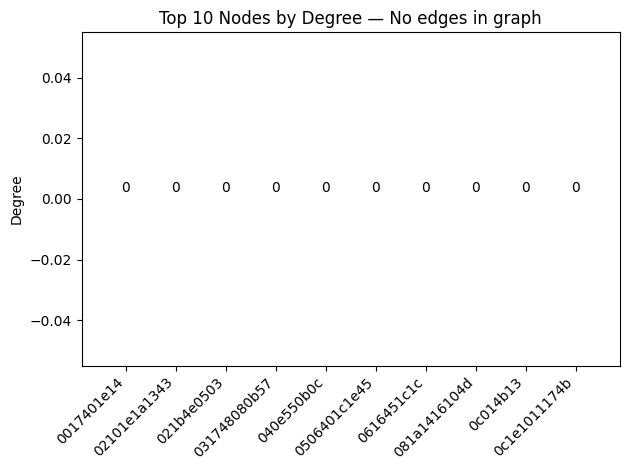

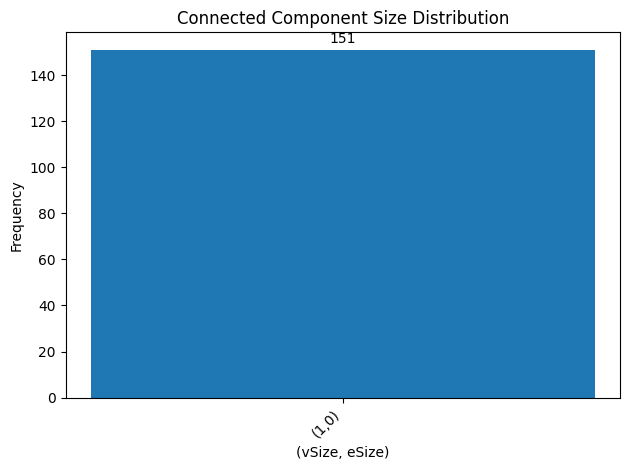

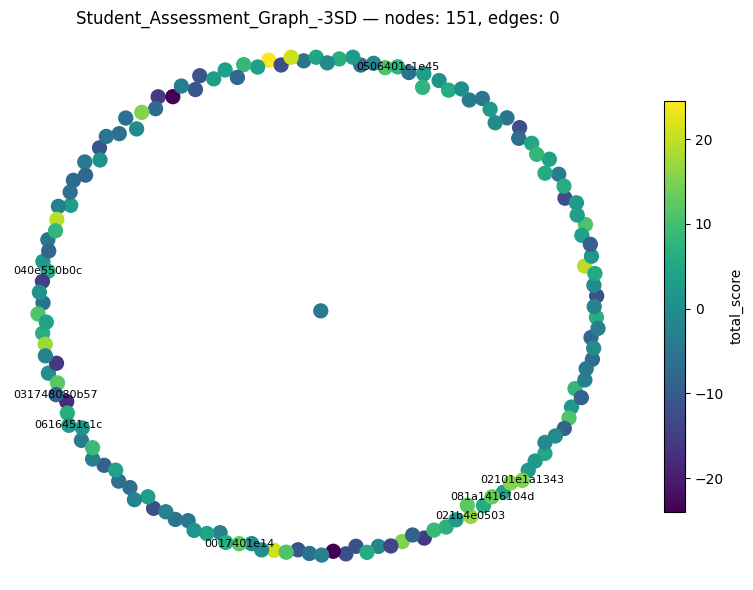

Graph saved to Student_Assessment_Graph_-3SD.json

--- Analysis for Student_Assessment_Graph_-2SD ---

Top 10% (10 students) by degree:
              netid  total_score
13       9a899f989a    -5.679096
14       4743505959   -12.195626
16     f0c08cd0d58b   -15.471553
34       6c68707077   -11.235986
51       c0d6cbcec4   -16.156869
71   d6cf94d6d68e9b   -11.978493
85     464a4347411c   -15.899809
86     b9adb8bcbbe4   -11.424257
147    d6da8cd2d28d   -15.052428
149    fce8fefdf5a0   -13.913913


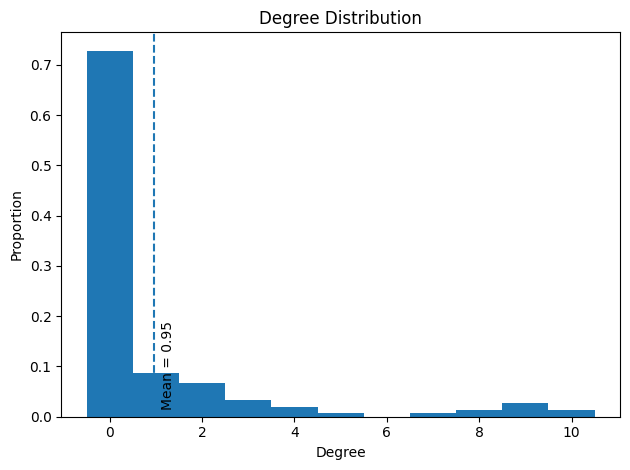

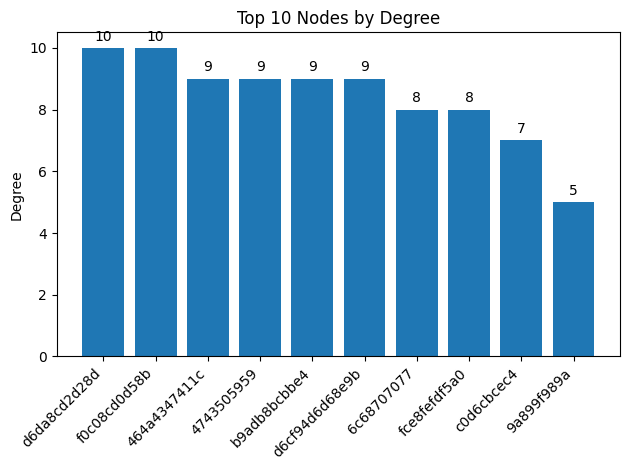

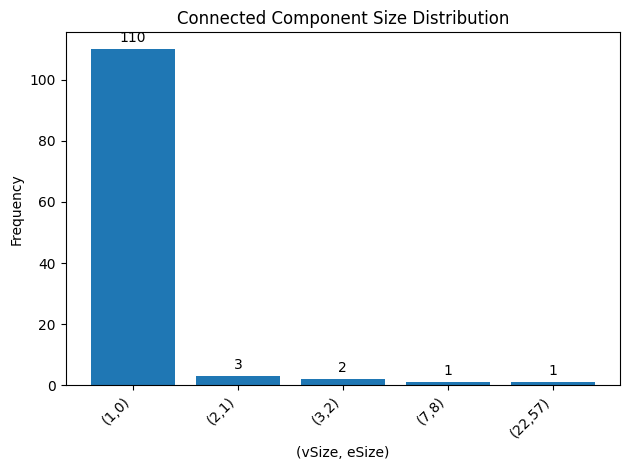

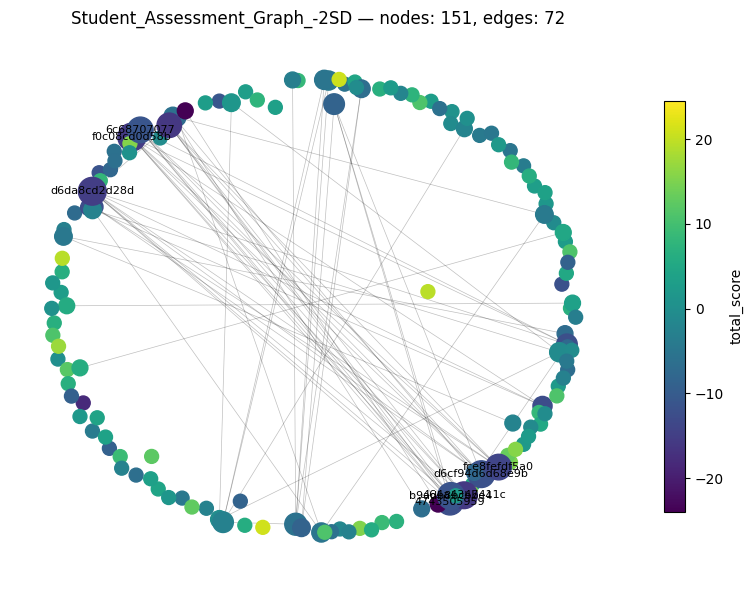

Graph saved to Student_Assessment_Graph_-2SD.json

--- Analysis for Student_Assessment_Graph_-1SD ---

Top 10% (10 students) by degree:
           netid  total_score
13    9a899f989a    -5.679096
18      5c7e2c66    -5.141247
22    717b747272    -7.112904
43  716573707023    -6.674910
45  dec2dadedf87    -5.958399
49  4a4f00414012    -2.834475
50    c5c99ed8de    -4.586530
56    373e6a3439    -3.819645
70  3a2d3138356e    -8.761186
77  0d367927237d    -8.743185


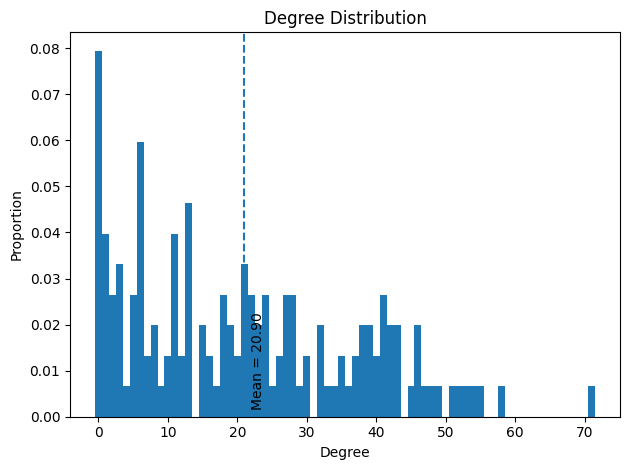

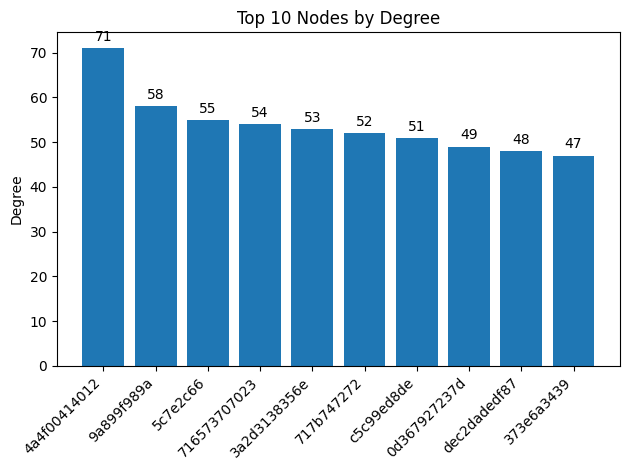

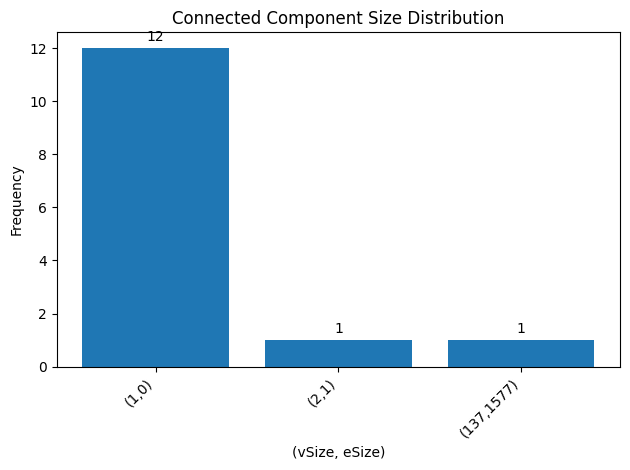

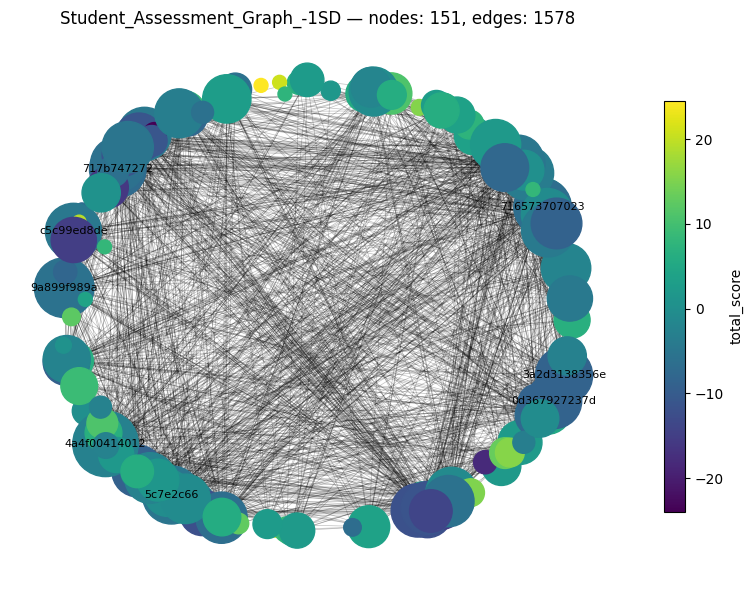

Graph saved to Student_Assessment_Graph_-1SD.json


In [30]:
if __name__ == "__main__":
    for name, graph in graphs.items():
        print(f"\n--- Analysis for {name} ---")
        analysis_results = analyze_graph(graph, final_df)
        top_10_netids = [netid for netid, _ in analysis_results['top_10_nodes']]
        top_10_info = final_df[final_df['netid'].isin(top_10_netids)][['netid', 'total_score']]
        print(f"\nTop 10% ({len(top_10_info)} students) by degree:")
        print(top_10_info)

        plot_degree_distribution(graph, analysis_results)

        comp_size_freq = compute_cc_size_frequency(analysis_results['comp_sizes'])
        plot_cc_size_distribution(comp_size_freq)


        plot_graph_layout(graph)
        
        save_graph_to_json(graph)

After exporting each graph to JSON, the files may be visualized interactively using `2D-vis.html` or `3D-vis.html`.

To encode vertex colors according to the `total_score` attribute, include a `color` property for each node in the JSON representation.

Suggested procedure:
1. Map the `total_score` values to an appropriate color scale (for example, a sequential or diverging colormap).
2. Convert the mapped color values to a hexadecimal RGB string (for example `#66ccff`).
3. Assign the resulting hex string to the node's `color` property, e.g. `node["color"] = "#66ccff"`.

An example of the expected JSON structure is shown below:
```json
{
  "nodes": [
    { "id": "node1", "total_score": 1.23, "color": "#66ccff" },
    { "id": "node2", "total_score": 2.34, "color": "#ff0000" },
    ...
  ],
  "links": [
    { "source": "node1", "target": "node2" },
    ...
  ]
}
```

When such a JSON file is loaded into `2D-vis.html` or `3D-vis.html`, the renderer will apply the specified `color` values to the vertices, producing a visualization in which node colors reflect their `total_score`.